In [18]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [27]:
TEMPERATURES_CSV = '/content/daily-minimum-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")


Header looks like this:

Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"

First data point looks like this:

1/1/1981,20.7

Second data point looks like this:

1/2/1981,17.9



In [28]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [31]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        reader = csv.reader(csvfile)
        
        next(reader)
        
        for row in reader:
            temperatures.append(float(row[1]))
        
        times = np.arange(0,len(temperatures))
 
            
    return times, temperatures


In [32]:
@dataclass
class G:
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


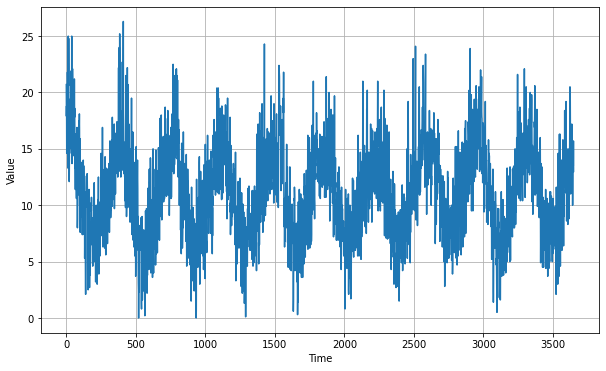

In [33]:
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [34]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


In [35]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [36]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [44]:
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [37]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation = 'relu', input_shape = [None, 1]),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1)
        
    ]) 

    return model

In [45]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

77/77 [==============================] - 8s 5ms/step
Your current architecture is compatible with the windowed dataset! :)


In [46]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    
    optimizer = tf.keras.optimizers.Adam()
 
    model.compile(loss='mae',
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history


In [47]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 4s 8ms/step - loss: 8.9979 - mae: 8.9979 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 1s 8ms/step - loss: 6.1663 - mae: 6.1663 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 1s 11ms/step - loss: 4.1841 - mae: 4.1841 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 1s 8ms/step - loss: 3.2905 - mae: 3.2905 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 1s 8ms/step - loss: 2.8168 - mae: 2.8168 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 1s 8ms/step - loss: 2.5677 - mae: 2.5677 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 1s 8ms/step - loss: 2.4266 - mae: 2.4266 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 1s 8ms/step - loss: 2.3191 - mae: 2.3191 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 1s 8ms/step - loss: 2.2449 - mae: 2.2449 - lr: 2.5119e-04


(0.0001, 10.0, 0.0, 10.0)

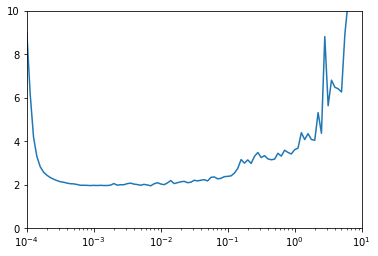

In [48]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])


In [49]:
def create_model():

    
    model = create_uncompiled_model()



    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 10e-3),
                  metrics=["mae"])  
    


    return model


In [50]:
model = create_model()

callback = tf.keras.callbacks.EarlyStopping(monitor = 'mae', patience = 3)

history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 2s 9ms/step - loss: 3.3109 - mae: 3.3109
Epoch 2/50
77/77 [==============================] - 1s 8ms/step - loss: 2.1722 - mae: 2.1722
Epoch 3/50
77/77 [==============================] - 1s 8ms/step - loss: 2.0940 - mae: 2.0940
Epoch 4/50
77/77 [==============================] - 1s 8ms/step - loss: 2.0536 - mae: 2.0536
Epoch 5/50
77/77 [==============================] - 1s 7ms/step - loss: 2.0805 - mae: 2.0805
Epoch 6/50
77/77 [==============================] - 1s 8ms/step - loss: 2.0401 - mae: 2.0401
Epoch 7/50
77/77 [==============================] - 1s 8ms/step - loss: 2.0161 - mae: 2.0161
Epoch 8/50
77/77 [==============================] - 1s 8ms/step - loss: 2.0195 - mae: 2.0195
Epoch 9/50
77/77 [==============================] - 1s 8ms/step - loss: 2.0036 - mae: 2.0036
Epoch 10/50
77/77 [==============================] - 1s 8ms/step - loss: 2.0780 - mae: 2.0780
Epoch 11/50
77/77 [==============================] - 1s 8ms/step - lo

In [51]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [52]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [54]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

113/113 [==============================] - 1s 6ms/step


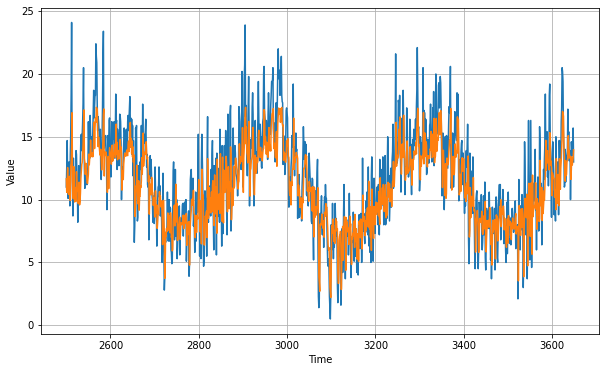

In [55]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [56]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.89, mae: 1.92 for forecast
